In [1]:
import random
from random import randrange

from ase.io import write
from ase.data import atomic_numbers
from ase.ga.data import PrepareDB
from ase.visualize import view
from ase.calculators.siesta import Siesta
from ase.units import Ry

import numpy as np
import os

from pyxtal import pyxtal
# from pyxtal.crystal import Lattice
# from pyxtal.crystal import random_crystal_2D
# from pyxtal.crystal import Tol_matrix



import seaborn as sns
import pandas as pd

## Inputs

In [2]:
name = 'MoS2'                                    # Name of the structure 
file_name = f'DateBase_{name}_rulette.txt'       # File name
species = ['Mo', 'S']                            # Chemical species of the structure
quantity = [1, 2]                                # Quantity of chemical species in elemental cell
thickness = 5.0                                  # Thickness of the structure

pop_size = 10                                    # Number of structures in population
prob= 0.3                                        # Percentage of best indyviduals passing to the next generation
n_gen = 4                                        # Number of generations

In [3]:
def dist(v1, v2): 
    """Returns distance two atoms

    Args:
        v1 ( list[float] ): First vector 
        v2 ( list[float] ): Second vector

    Returns:
        float: Distance of two vectors
    """
    
    d = np.sqrt((v1[0] - v2[0]) * (v1[0] - v2[0]) + (v1[1] - v2[1]) * (v1[1] - v2[1]) + (v1[2] - v2[2]) * (v1[2] - v2[2]))
    return d

In [4]:
def check_dist(number_atoms, positions, d_min, d_max):
    """Restrict of the distance between atoms 

    Args:
        number_atoms (int): Number of atoms
        positions (array[float]): Atom positions   
        d_min (float): Minimum allowable distance
        d_max (float): Maximum allowable distance

    Returns:
        bool: Returns True if conditions are fulfilled anyway False
    """

    flag = True
    for i in range(number_atoms):
        for j in range(number_atoms):
            if i != j:
                distance = dist(positions[i], positions[j])
                if (distance < d_min) or (distance > d_max):
                    flag = False
    return flag

# Structure Initialisation 

In [5]:
def init_atoms():  
    """Initialization of the structure

    Returns:
        ase.Atoms: Structure
    """

    atoms_out = None

    number_attempts = 200 # no of attempts
    d_min = 1.0 # min distance
    d_max = 2.5 # max distance
    
    for i in range(number_attempts):
        group_id = randrange(80) + 1 
        my_crystal = pyxtal()
        
        try:
            my_crystal.from_random(2, group_id, species, quantity, thickness=thickness)
        except RuntimeError:
            continue
        
        atoms = my_crystal.to_ase()
        positions = atoms.get_positions()
        number_atoms = len(atoms.get_chemical_symbols()) 
        


        flag = check_dist(number_atoms, positions, d_min, d_max)
        
        if flag==True:
            atoms_out = atoms
            break
    return atoms_out

## Siesta calculator 
Siesta User's Guide: <https://departments.icmab.es/leem/SIESTA_MATERIAL/Docs/Manuals/siesta-4.1-b4.pdf> 

In [6]:
calc = Siesta(label=name,       
               xc='PBE',
               mesh_cutoff=200 * Ry,
               energy_shift=0.01 * Ry,
               basis_set='SZP',
               kpts=[12, 12, 1],
               pseudo_path='/home/czeski/Pobrane/siesta-4.1-b4/pseudo',
               fdf_arguments={'MaxSCFIterations': 500,   
                              'DM.Tolerance': 1.E-5,
                              'DM.NumberPulay': 6,                        
                              'DM.NumberBroyden': 0,
                              'DM.MixingWeight': 0.1000000000,             
                              'DM.OccupancyTolerance':0.1000000000E-11,         
                              'DM.NumberKick': 0,                        
                              'DM.KickMixingWeight': 0.5000000000,
                              'MD.NumCGsteps': 150,                        
                              'MD.TypeOfRun': 'CG',                       
                              'MD.VariableCell': 'F',                        
                              'WriteMullikenPop': 1,    
                              'WriteDenchar': True,      
                              'WriteKpoints': True,      
                              'WriteForces': True,      
                              'WriteDM': True,      
                              'WriteXML': True,      
                              'WriteEigenvalues': False, 
                              'WriteCoorStep': True,      
                              'WriteMDhistory': True,    
                              'WriteMDXmol': True,      
                              'WriteCoorXmol': True, 
                             },)

## Indyvidual

In [7]:
class Indyvidual:
    def __init__(self, structure,n_gen):
        """ Indyvidual constructor

        Args:
            structure (ase.Atoms) : Atom 
            n_gen (int) : Number of the generation
        """
        
        self.calc = calc                    
        self.init_structure = structure     
        self.energy = 0.0
        self.ngen = n_gen
        self.status = 'Random'
        
    def calc_energy(self):
        try:
            self.init_structure.calc = calc
            self.energy = self.init_structure.get_potential_energy()
        except:
            print("energy calculation failed")
            self.energy = +1000.
    def next_gen(self):
        self.ngen = self.ngen + 1
        
    def mutation(self):
        positions = self.init_structure.get_positions()
        new = [ n + (random.random()-0.5) for n in positions]    
        self.init_structure.set_positions(new)
        self.status = 'Mutated'
    
    def get_init_structure(self):
        return self.init_structure.copy()
    
    def get_energy(self):
        return self.energy
    
    def get_ngen(self):
        return self.ngen
    
    def get_position(self):
        return self.init_structure.get_positions()
    
    def get_status(self):
        """Returns where the individual came from.

        Returns:
            str: Origin of the individual
        """
        return self.status
    

    

In [8]:
def energy_sorting(pop):
    """Sorts arrays from the lowest energy to the highest.
       Prints all population

    Args:
        pop ( array[ase.Atoms] ): Populaion of indyviduals 

    Returns:
        array[ase.Atoms] : Sorted population of indyviduals
    """
    
    for i in range(len(pop)):
            pop[i].calc_energy()        
    sorted_pop = sorted(pop, key=lambda x: x.energy) 

    # Printing sorted energy
    for i in range(len(sorted_pop)):
        print(sorted_pop[i].get_energy())

    return sorted_pop
    

## Choice by Rulette 

In [10]:
def choice_by_rulette(pop):
    """ Choice the Indyvidual of the population to mutation

    Args:
        pop ( array[Ase.Atoms]): [description]

    Returns:
        int: Number of indyvidual chosen to mutation
    """
    
    #Totaly population fitness
    population_sum = sum([individual.get_energy() for individual in pop])
    
    #Each individual probability
    individuals_prob = [individual.get_energy()/population_sum for individual in pop]
    
    n = np.arange(0,len(pop))#The best indyvidual in untouchable
    while True:
        chosen_num =  np.random.choice(n, p=individuals_prob)
        if chosen_num !=0:
            return chosen_num



## Starting population

In [11]:
number_indyviduals =int(prob*pop_size)         #Amount of individuals going to the next generation
arr = np.arange(number_indyviduals,pop_size)   #Array of iterations
best = []                                      #Array of best indyviduals
data = []                                      #Array for data base

f=open(file_name, "w")


#Preapering first population
pop = [] 
i=1
while (len(pop)<pop_size):
    pop.append(Indyvidual(init_atoms(), 1))
    i=i+1

sorted_pop = energy_sorting(pop)
data.append(sorted_pop)                         #Collecting data
best.append(sorted_pop[0].get_energy())

/home/czeski/anaconda3/lib/python3.8/site-packages/pyxtal/msg.py:21: UserWarning: Error: the stoichiometry is incompatible with wyckoff choice
  warn(text)


-776.86678
-773.919864
-771.391352
-765.82226
-763.732979
-745.779858
-742.99414
-742.935519
-730.551948
-687.454887


## Next Generation - Choice by Roulette

In [12]:
for g in range(n_gen):

    # % of the best individuals go to the next generation
    new_pop = sorted_pop[0 : int(prob*pop_size)]         

    chosen = choice_by_rulette(new_pop)
    new_pop[chosen].mutation()
    new_pop[chosen].calc_energy()
    
    #Appending new random individuals
    while (len(new_pop)<(pop_size)):                   
        new_pop.append(Indyvidual(init_atoms(), g+2))
    
    
    #Calculating energy of new individuals
    for i in arr:
        new_pop[i].calc_energy()                 

    #Sorting Population
    sorted_pop = sorted(new_pop, key=lambda x: x.energy)
    
    print("\nGeneration nr:",g + 1)
    print("Sorted Energies:")
    
    for i in range(len(sorted_pop)):
        print(sorted_pop[i].get_energy())
    best.append(sorted_pop[0].get_energy())
    
    data.append(sorted_pop)
    write(filename=f"BestStructGen{g+1}rulette{name}.in", images=sorted_pop[0].init_structure, format='espresso-in')
    





Generation nr: 1
Sorted Energies:
-776.86678
-775.810194
-775.261903
-773.919864
-773.564653
-768.094236
-749.633903
-736.955444
-732.559681
-731.092342

Generation nr: 2
Sorted Energies:
-776.86678
-775.811489
-775.40414
-775.261903
-775.24641
-775.206735
-766.571203
-760.822229
-743.53504
-725.35786

Generation nr: 3
Sorted Energies:
-776.86678
-775.812644
-775.40414
-773.784293
-772.591043
-769.965729
-769.772582
-769.691377
-769.275797
-760.404518

Generation nr: 4
Sorted Energies:
-776.86678
-775.815318
-775.698984
-775.40414
-772.106829
-771.409265
-770.320861
-769.801763
-769.00255
-721.437406


## View Best Individual

In [23]:
from ase import Atoms
from ase_notebook import AseView, ViewConfig, get_example_atoms

config = ViewConfig()
ase_view = AseView(config)

ase_view = AseView(
    rotations="0x,0y,0z",
    atom_font_size=16,
    axes_length=30,
    canvas_size=(400, 400),
    zoom=1.2,
    show_bonds=True
)
ase_view.config.uc_dash_pattern=(.6,.4)
ase_view.add_miller_plane(
    1, 0, 0, color="green")
ase_view.config



ase_view.config.canvas_color_background = "white"
ase_view.config.canvas_background_opacity = 0
gui = ase_view.make_render(
    sorted_pop[0].get_init_structure() , center_in_uc=True)
gui

GridspecLayout(children=(Renderer(camera=PerspectiveCamera(fov=10.0, position=(0.0, 0.0, 48.37911695490864), p…

## Creating Database 

In [14]:
ind = []
for i in range(len(data)):
    for j in range(pop_size):
        ind.append(data[i][j])    

In [16]:
d = {'indyvidual': ind}
df=pd.DataFrame(data = d)
df

def get_energyDF(x):
    return x.get_energy()

def get_ngenDF(x):
    return x.get_ngen()

def get_statusDF(x):
    return x.get_status()


df['energy'] = df['indyvidual'].apply(get_energyDF)
df['n_gen'] = df['indyvidual'].apply(get_ngenDF)
df['status'] = df['indyvidual'].apply(get_statusDF)

df = df.drop_duplicates(subset=['indyvidual'], keep='last')
df.sort_values('energy')


,indyvidual,energy,n_gen,status
40,<__main__.Indyvidual object at 0x7f921c1b0580>,-776.866780,1,Random
41,<__main__.Indyvidual object at 0x7f91b870e0a0>,-775.815318,2,Mutated
42,<__main__.Indyvidual object at 0x7f91ba7a0700>,-775.698984,5,Random
43,<__main__.Indyvidual object at 0x7f91ba7d9520>,-775.404140,3,Random
23,<__main__.Indyvidual object at 0x7f91ba8f3b20>,-775.261903,2,Random
24,<__main__.Indyvidual object at 0x7f921c263f70>,-775.246410,3,Random
25,<__main__.Indyvidual object at 0x7f91ba8f3730>,-775.206735,3,Random
13,<__main__.Indyvidual object at 0x7f91ba79ceb0>,-773.919864,1,Random
33,<__main__.Indyvidual object at 0x7f91b870e1c0>,-773.784293,4,Random
14,<__main__.Indyvidual object at 0x7f921c254df0>,-773.564653,1,Mutated


#### Writting best structure espresso_in file 
#### Writting DataBase to csv

In [ ]:
write(filename=f"TheBestStruct_{name}.in", images=sorted_pop[0].init_structure, format='espresso-in')
df.to_csv(f"DataBase_{name}.csv")

#### Creating best Indyviduals Plot

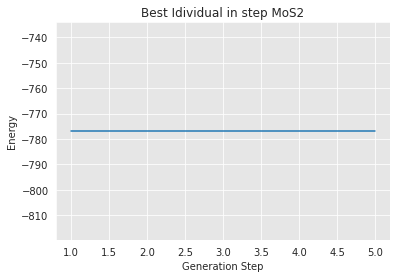

In [22]:
f = sns.lineplot(x=np.arange(1, n_gen+2), y=best)
f.set(xlabel='Generation Step', ylabel='Energy', title=f'Best Idividual in step {name}')
sns.axes_style()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})